# Getting Started with Azure ML Notebooks and Azure Sentinel
**Notebook Version:** 1.0<br>
 **Python Version:** Python 3.6 (including Python 3.6 - AzureML)<br>
 **Required Packages**: <br>
 **Platforms Supported**:
 - Azure Notebooks Free Compute
 - Azure Notebooks DSVM
 - OS Independent

**Data Sources Required**:
 - Log Analytics - SiginLogs (Optional)
 - VirusTotal
 - MaxMind
 
 
This notebook takes you through the basics needed to get started with Azure Notebooks and Azure Sentinel, and how to perform the basic actions of data acquisition, data enrichment, data analysis, and data visualization. These actions are the building blocks of threat hunting with notebooks and are useful to understand before running more complex notebooks. This notebook only lightly covers each topic but includes 'learn more' sections to provide you with the resource to deep dive into each of these topics. 

This notebook assumes that you are running this in an Azure Notebooks environment, however it will work in other Jupyter environments.

**Note:**
This notebooks uses SigninLogs from your Azure Sentinel Workspace. If you are not yet collecting SigninLogs configure this connector in the Azure Sentinel portal before running this notebook.
This notebook also uses the VirusTotal API for data enrichment, for this you will require an API key which can be obtained by signing up for a free [VirusTotal community account](https://www.virustotal.com/gui/join-us)


---
## What is a Jupyter notebook?
You are currently reading a Jupyter notebook. [Jupyter](http://jupyter.org/) is an interactive development and data manipulation environment presented in a browser. Using Jupyter you can create documents, called Notebooks. These documents are made up of cells that contain interactive code, alongside that code's output, and other items such as text and images (what you are looking at now is a cell of Markdown text).

The name, Jupyter, comes from the core supported programming languages that it supports: Julia, Python, and R. Whilst you can use any of these languages we are going to use Python in this notebook, in addition the notebooks that come with Azure Sentinel are all written in Python. Whilst there are pros, and cons to each language Python is a well-established language that has a large number of materials and libraries well suited for data analysis and security investigation, making it ideal for our needs.

### Learn more:
 - The [Infosec Jupyter Book](https://infosecjupyterbook.com/introduction.html) has more details on the technical working of Jupyter.
 - [The Jupyter Project documentation](https://jupyter.org/documentation)

---
## How to use a Jupyter notebook?
To use a Jupyter notebook you need a Jupyter server that will render the notebook and execute the code within it. This can take the form of a local [Jupyter installation](https://pypi.org/project/jupyter/), or a remotely hosted version such as [Azure Notebooks](https://notebooks.azure.com/). If you are reading this it is highly likely that you already have a Jupyter server that this notebook is using.
You can learn more about installing and running your own Jupyter server [here](https://realpython.com/jupyter-notebook-introduction/).

### Using Azure Notebooks
If you accessed this notebook from Azure Sentinel,  you are probably using Azure Notebooks to run this notebook. Azure Notebooks runs in the same way that a local Jupyter server with, except with the additional feature of integrated project management and file storage. When you open a notebook in Azure Notebooks the user interface is nearly identical to a standard Jupyter notebook experience.

Before you can start running code in a notebook you need to make sure that it is connected to a Jupyter server and you have the correct type of kernel configured. For this notebook we are going to be using Python 3.6, hopefully Azure Notebooks has already loaded this kernel for you - you can check this by looking at the top left corner of the screen where you should see the currently connected kernel. 

![KernelIssue](https://github.com/Azure/Azure-Sentinel-Notebooks/raw/master/images/nb_img1.png)

If this does not read Python 3.6 you can select the correct kernel by selecting Kernel > Change kernel from the top menu and clicking Python 3.6.

> **Note**: the notebook works with Python 3.6, 3.7 or later. If you are using this notebook in Azure ML or another Jupyter environment you can choose any kernel that supports Python 3.6 or later

![KernelPicker](https://github.com/Azure/Azure-Sentinel-Notebooks/raw/master/images/nb_img2.png)

Once you have done this you should be ready to move onto a code cell.
> **Tip**: You can identify which cells are code by selecting them and looking at the drop down box at the center of the top menu. It will either read 'Code' (for interactive code cells), 'Markdown' (for Markdown text cells like this one), or RawNBConvert (these are just raw data and not interpreted by Jupyter - they can be used by tools that process notebook files, such as *nbconvert* to render the data into HTML or LaTeX). 

If you click on the cell below you should see this box change to 'Code'.

### Learn More:
More details on Azure Notebooks can be found in the [Azure Notebooks documentation](https://docs.microsoft.com/en-us/azure/notebooks/) and the [Azure Sentinel documentation](https://docs.microsoft.com/en-us/azure/sentinel/notebooks).

---
## Running code
Once you have selected a code cell you can run it by clicking the run button at the menu bar at the top, or by pressing Ctrl+Enter.


In [ ]:
# This is our first code cell, it contains basic Python code.
# You can run a code cell by selecting it and clicking the Run button in the top menu, or by pressing Shift + Enter.
# Once you run a code cell any output from that code will be displayed directly below it.
print("Congratulations you just ran this code cell")
y = 2+2
print("2 + 2 =", y)

Variables set within a code cell persist between cells meaning you can chain cells together

In [ ]:
y + 2

### Learn More : 
 - The [Infosec Jupyter Book](https://infosecjupyterbook.com/) provides an infosec specific intro to Python.
 - [Real Python](https://realpython.com/) is a comprehensive set of Python learnings and tutorials.
<br>
<br>

Now that you understand the basics we can move onto more complex code.

---
## Setting up the environment
Code cells behave in the same way your code would in other environments, so you need to remember about common coding practices such as variable initialization and library imports. 
Before we execute more complex code we need to make sure the required packages are installed and libraries imported. At the top of many of the Azure Sentinel notebooks you will see large cells that will check kernel versions and then install and import all the libraries we are going to be using in the notebook, make sure you run this before running other cells in the notebook.
If you are running notebooks locally or via dedicated compute in Azure Notebooks library installs will persist but this is not the case with Azure Notebooks free tier, so you will need to install each time you run. Even if running in a static environment imports are required for each run so make sure you run this cell regardless.

In [ ]:
from pathlib import Path
from IPython.display import display, HTML

REQ_PYTHON_VER=(3, 6)
REQ_MSTICPY_VER=(1, 0, 0)
REQ_MP_EXTRAS=["Azure"]

display(HTML("<h3>Starting Notebook setup...</h3>"))
if Path("./utils/nb_check.py").is_file():
    from utils.nb_check import check_versions
    check_versions(REQ_PYTHON_VER, REQ_MSTICPY_VER, REQ_MP_EXTRAS)
            
from msticpy.nbtools import nbinit
nbinit.init_notebook(
    namespace=globals(),
    extra_imports=["urllib.request, urlretrieve", "yaml"]
);

pd.set_option("display.html.table_schema", False)

---
## Configuration
Once we have set up our Jupyter environment with the libraries that we'll use in the notebook, we need to make sure we have some configuration in place. Some of the notebook components need addtional configuration to connect to external services (e.g. API keys to retrieve Threat Intelligence data). This includes configuration for connection to our Azure Sentinel workspace, as well as some threat intelligence providers we will use later.
The easiest way to handle the configuration for these services is to store them in a msticpyconfig file (`msticpyconfig.yaml`). More details on msticpyconfig can be found here:
- [MSTICPy Package Configuration](https://msticpy.readthedocs.io/en/latest/getting_started/msticpyconfig.html)<br>
- [MSTICPy Settings Editor](https://msticpy.readthedocs.io/en/latest/getting_started/SettingsEditor.html)

### Learn more: 
- In this notebook we will setup the basic config we need to get started. If you need a more complete walk-through we have a separate notebook to help you: [Configuring Notebook Environment](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/ConfiguringNotebookEnvironment.ipynb)
- And for the ultimate walk-through of how to configure all your `msticpyconfig.yaml` settings see the [MPSettingsEditor notebook](https://github.com/microsoft/msticpy/blob/master/docs/notebooks/MPSettingsEditor.ipynb)

---

The Azure-Sentinel-Notebooks GitHub repo contains an template `msticpyconfig.yaml` file ready to be populated. If you have run this notebook before you may have a msticpyconfig file already populated, the cell below allows you to checks if this file. If your config file does not contain details under Azure Sentinel/Workspaces, or TIProviders the following cells will populate these for you.<br>

If you want to see an example of what a populated msticpyconfig file should look like a samples is included in the repo as msticpyconfig-sample.yaml. Or [this example](https://msticpy.readthedocs.io/en/latest/getting_started/msticpyconfig.html#commented-configuration-file-sample)
in the MSTICPy documentation.

In [ ]:
from msticpy.config import MpConfigFile, MpConfigEdit
mpconfig = MpConfigFile()
mpconfig.load_default()
mpconfig.view_settings()

If you see nothing but a pair of curly braces in the settings view above it means
that you should set up a **msticpyconfig.yaml**.

### Two options - with and without a `config.json` file

#### Plan A - If you have a config.json file

**Step 1 - Find your config.json**

A `config.json` is created for you if you launched a notebook from Azure Sentinel. It should
be in the root of your user folder in the Azure Sentinel Machine learning workspace.<br>

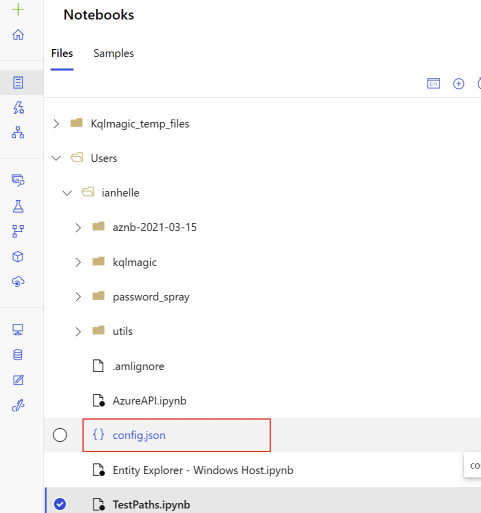

**Step 2 - Import and convert this file**

In [ ]:
mpconfig = MpConfigFile()
mpconfig.load_from_file("config.json")
mpconfig.map_json_to_mp_ws()
mpconfig.settings

The output should look something like this
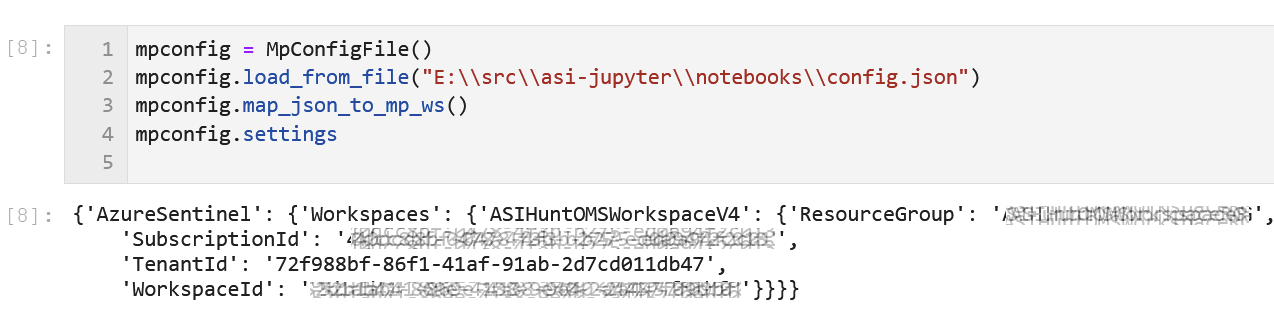

**Step 3 - Import these settings into the editor**

In [ ]:
mpedit = MpConfigEdit(settings=mpconfig)
mpedit.set_tab("AzureSentinel")
mpedit

#### Plan B - If you do not have a config.json
You will need to find your Azure Sentinel workspace ID, Azure TenantId and, optionally the SubscriptionId, ResourceGroup name and Workspace name.

You can get the workspace ID by opening Azure Sentinel in the Azure Portal and selecting Settings > Workspace Settings. Your Workspace ID is displayed near the top of this page.

If you don't know your Azure tenant ID you can use this code to get it, given the Subscription ID. (replace `{subscription-id}` with the subscription UUID that you obtained in the previous step.

```python
from msticpy.common.config.ce_common import get_def_tenant_id
get_def_tenant_id("{subscription-id}")
```
You can get your tenant ID (also referred to organization or directory ID) via [Azure Active Directory](https://docs.microsoft.com/en-us/onedrive/find-your-office-365-tenant-id)

Open the MpConfigEdit tool and manually create a workspace entry.

You can give the workspace any name you like. It makes sense to keep this similar to
the actual workspace name but you can shorten it to make it easier to remember.

In [ ]:
mpedit = MpConfigEdit()
mpedit.set_tab("AzureSentinel")
mpedit

### Create a copy of your workspace entry as a Default
Make sure your workspace settings are selected and displayed and hit the **Set as Default** button.

In [ ]:
import yaml
def print_config():
    with open('msticpyconfig.yaml') as f:
        data = yaml.load(f, Loader=yaml.FullLoader)
        print(yaml.dump(data))
try:
    print_config()
except FileNotFoundError:
    print("No msticpyconfig.yaml was found in your current directory.")
    print("We are downloading a template file for you.")
    urlretrieve("https://raw.githubusercontent.com/Azure/Azure-Sentinel-Notebooks/master/msticpyconfig.yaml", "msticpyconfig.yaml")
    print_config()

### Adding Threat Intel and GeoIP providers

We are going to use [VirusTotal](https://www.virustotal.com) to enrich our Azure Sentinel data. For this you will need a VirusTotal API key, one of these can be obtained for free (as a personnal key) via the [VirusTotal](https://developers.virustotal.com/v3.0/reference#getting-started) website.
We are using VirusTotal for this notebook but we also support a range of other threat intelligence providers: https://msticpy.readthedocs.io/en/latest/data_acquisition/TIProviders.html
<br><br>
In addition we are going to plot IP address locations on a map, in order to do this we are going to use [MaxMind](https://www.maxmind.com) to geolocate IP addresses which requires an API key. You can sign up for a free account and API key at https://www.maxmind.com/en/geolite2/signup. 
<br><br>
To add the VirusTotal details, run the following cell.

If you are unclear about what anything means use the **Help** drop-down. This
has instructions and links to more detailed documentation.

In [ ]:
mpedit.set_tab("TI Providers")
mpedit

To add the Maxmind GeopIP Lite details, run the following cell.

In [ ]:
mpedit.set_tab("GeoIP Providers")
mpedit

### Validate your settings
- click on **Validate settings**

You may see some warnings about missing sections but not about the Azure Sentinel, TIProviders or GeoIP Providers settings.

### Save the settings
- type in a path to the desired file location into the **Conf File** text box
- click on **Save File**

### Set a `MSTICPYCONFIG` environment variable so that you can always find your `msticpyconfig.yaml`

**On Azure ML**

If you are using Azure ML you will need to have this file in a location
accessible to the Azure ML compute - this means either in the AzureML filestore
or on the filesystem (usually the home directory) of the Compute instance.

If you are storing secrets such as API keys in the file you should
probably opt to store the file on the compute instance.

For more detailed instructions, please see the *Setting the path to your msticpyconfig.yaml* section
in the [Configuring Notebook Environment](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/ConfiguringNotebookEnvironment.ipynb).

Add one of the following lines to the `~/.bashrc` file.
If you moved `msticpyconfig.yaml` to the home directory on the compute instance.
```bash
export MSTICPYCONFIG=~/msticpyconfig.yaml
```
If you opted to leave `msticpyconfig.yaml` in the AzureML file store.
```bash
export MSTICPYCONFIG=~/cloudfiles/code/Users/YOURNAME/msticpyconfig.yaml
```
(replace `YOURNAME` with your user name)

**Locally or elsewhere**

How you set an environment variable depends on your operating system.
- On Windows
  - open **Settings**
  - click **System**
  - select **About** from the left-side menu
  - click on **Advanced system settings** (on the right of the window)
  - select the **Advanced** tab and click on the **Environment Variables...** button
  - add either a user or system variable named MSTICPYCONFIG with the path to your config file as its value.
  
- On Linux/MAC
  - Add the following to your .bashrc file (phew that was easy!)
  ```bash
  export MSTICPYCONFIG=~/.msticpyconfig.yaml
  ```
Here we've opted to name the file .msticpyconfig.yaml and store it in our home directory. You can
change either of these.

---
## Getting Data
Now that we have configured the details necessary to connect to Azure Sentinel we can go ahead and get some data. We will do this with `QueryProvider()` from MSTICpy. 
You can use the `QueryProvider` class to connect to different data sources such as MDATP, the Security Graph API, and the one we will use here, Azure Sentinel. 

### Learn more:
 - More details on configuring and using QueryProviders can be found in the [MSTICpy Documentation](https://msticpy.readthedocs.io/en/latest/data_acquisition/DataProviders.html#instantiating-a-query-provider).
<br><br>

For now, we are going to set up a QueryProvider for Azure Sentinel, pass it the details for our workspace that we just stored in the msticpyconfig file, and connect. The connection process will ask us to authenticate to our Azure Sentinel workspace via [device authorization](https://docs.microsoft.com/en-us/azure/active-directory/develop/v2-oauth2-device-code) with our Azure credentials. You can do this by clicking the device login code button that appears as the output of the next cell, or by navigating to https://microsoft.com/devicelogin and manually entering the code. Note that this authentication persists with the kernel you are using with the notebook, so if you restart the kernel you will need to re-authenticate.


In [ ]:
# Initalize a QueryProvider for Azure Sentinel
qry_prov = QueryProvider("LogAnalytics")

# Get the Azure Sentinel workspace details from msticpyconfig
try:
    ws_config = WorkspaceConfig()
    md("Workspace details collected from config file")
except:
    raise Exception("No workspace settings are configured, please run the cells above to configure these.")
    
# Connect to Azure Sentinel with our QueryProvider and config details
# ws_config.code_connect_str is a feature of MSTICpy that creates the required connection string from details in our msticpyconfig
qry_prov.connect(connection_str=ws_config.code_connect_str)

Now that we have connected we can query Azure Sentinel for data, but before we do that we need to understand what data is avalaible to query. The QueryProvider object provides a way to get a list of tables as well as tables and table columns:

In [ ]:
# Get list of tables in our Workspace
display(qry_prov.schema_tables [:5]) # We are outputting only the first 5 tables for brevity
# Get list of tables and thier columns
qry_prov.schema['SigninLogs'] # We are only displaying the columns for SigninLogs for brevity

MSTICpy includes a number of built in queries that you can run.<br>
You can list available queries with .list_queries() and get specific details about a query by calling it with "?" as a parameter

In [ ]:
# Get a list of avaliable queries
qry_prov.list_queries()

In [ ]:
# Get details about a query
qry_prov.Azure.list_all_signins_geo("?")

You can then run the query by calling it with the required parameters:

In [ ]:
from datetime import datetime, timedelta
# set our query end time as now
end = datetime.now()
# set our query start time as 1 hour ago
start = end - timedelta(hours=1)
# run query with specified start and end times
logons_df = qry_prov.Azure.list_all_signins_geo(start=start, end=end)
# display first 5 rows of any results
logons_df.head() # If you have no data you will just see the column headings displayed

Another way to run queries is to pass a string format of a KQL query to the query provider, this will run the query against the workspace connected to above, and will return the data in a [Pandas DataFrame](https://pandas.pydata.org/). We will look at working with Pandas in a bit more detail later.

In [ ]:
# Define our query
test_query = """
SigninLogs
| where TimeGenerated > ago(7d)
| take 10
"""

# Pass that query to our QueryProvider
test_df = qry_prov.exec_query(test_query)

# Check that we have some data
if isinstance(test_df, pd.DataFrame) and not test_df.empty:
    # .head() returns the first 5 rows of our results DataFrame
    display(test_df.head())
# If where is no data load some sample data to use instead
else:
    md("You don't appear to have any SigninLogs - we will load sample data for you to use.")
    if not Path("nbdemo/data/aad_logons.pkl").exists():
        Path("nbdemo/data/").mkdir(parents=True, exist_ok=True)
        urlretrieve('https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/nbdemo/data/aad_logons.pkl?raw=true', 'nbdemo/data/aad_logons.pkl')
        urlretrieve('https://raw.githubusercontent.com/Azure/Azure-Sentinel-Notebooks/master/nbdemo/data/queries.yaml', 'nbdemo/data/queries.yaml')
    qry_prov = QueryProvider("LocalData", data_paths=["nbdemo/data/"], query_paths=["nbdemo/data/"])
    logons_df = qry_prov.Azure.list_all_signins_geo()
    display(logons_df.head())

### Learn more:
 - You can learn more about the MSTICpy pre-defined queries in the [MSTICpy Documentation](https://msticpy.readthedocs.io/en/latest/data_acquisition/DataProviders.html#running-an-pre-defined-query)

---
## Pandas
Our query results are returned in the form of a Pandas DataFrame. DataFrames are a core component of the Azure Sentinel notebooks and of MSTICpy and is used for both input and output formats.
Pandas DataFrames are incredibly versitile data structures with a lot of useful features, we will cover a small number of them here and we recommend that you check out the Learn more section to learn more about Pandas features.
<br>
<br>
### Displaying a DataFrame:
The first thing we want to do is display our DataFrame. You can either just run it or explicity display it by calling `display(df)`.

In [ ]:
# For this section we are going to create a DataFrame from data we have saved in a csv file
df = pd.read_csv("https://raw.githubusercontent.com/microsoft/msticpy/master/tests/testdata/host_logons.csv", index_col=[0] )
# Display our DataFrame
df  # or display(df)

> **Note** if the dataframe variable (`df` in the example above) is the last statement in a 
> code cell, Jupyter will automatically display it without using the `display()` function. 
> However, if you want to display a DataFrame in the middle of 
> other code in a cell you must use the `display()` function.

You may not want to display the whole DataFrame and instead display only a selection of items. There are numerous ways to do this and the cell below shows some of the most widely used functions.

In [ ]:
md("Display the first 2 rows using head(): ", "bold")
display(df.head(2))  # we don't need to call display here but just for illustration

In [ ]:
md("Display the 3rd row using iloc[]: ", "bold")
df.iloc[3]

In [ ]:
md("Show the column names in the DataFrame ", "bold")
df.columns

In [ ]:
md("Display just the TimeGenerated and TenantId columnns: ", "bold")
df[["TimeGenerated", "TenantId"]]

We can also choose to select a subsection of our DataFrame based on the contents of the DataFrame:

> **Tip**: the syntax in these examples is using a technique called *boolean indexing*. 
> <br>`df[<boolean expression>]`
> returns all rows in the dataframe where the boolean expression is True
> <br>In the first example we telling pandas to return all rows where the column value of
> 'TargetUserName' matches 'MSTICAdmin'

In [ ]:
md("Display only rows where TargetUserName value is 'MSTICAdmin': ", "bold")
df[df['TargetUserName'] == "MSTICAdmin"]

In [ ]:
md("Display rows where TargetUserName is either MSTICAdmin or adm1nistratror:", "bold")
display(df[df['TargetUserName'].isin(['adm1nistrator', 'MSTICAdmin'])])

Our DataFrame call also be extended to add new columns with additional data if required:

In [ ]:
df["NewCol"] = "Look at my new data!"  # Add the same string to every row in this column
display(df[["TenantId","Account", "TimeGenerated", "NewCol"]].head(2))

### Learn more:
There is a lot more you can do with Pandas, the links below provide some useful resources:
 - [Getting starting with Pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/index.html)
 - [Infosec Jupyerbook intro to Pandas](https://infosecjupyterbook.com/notebooks/tutorials/03_intro_to_pandas.html)
 - [A great list of Pandas hints and tricks](https://www.dataschool.io/python-pandas-tips-and-tricks/)

---
## Enriching data

Now that we have seen how to query for data, and do some basic manipulation we can look at enriching this data with additional data sources. For this we are going to use an external threat intelligence provider to give us some more details about an IP address we have in our dataset using the [MSTICpy TIProvider]("https://msticpy.readthedocs.io/en/latest/data_acquisition/TIProviders.html") feature.

In [ ]:
from datetime import datetime, timedelta
# Check if we have logon data already and if not get some
if not isinstance(logons_df, pd.DataFrame) or logons_df.empty:
    # set our query end time as now
    end = datetime.now()
    # set our query start time as 1 hour ago
    start = end - timedelta(days=1)
    # run query with specified start and end times
    logons_df = qry_prov.Azure.list_all_signins_geo(start=start, end=end)
    
# Create our TI provider
ti = TILookup()
# Get the first logon IP address from our dataset
ip = logons_df.iloc[1]['IPAddress']
# Look up the IP in VirusTotal
ti_resp = ti.lookup_ioc(ip, providers=["VirusTotal"])

# Format our results as a DataFrame
ti_resp = ti.result_to_df(ti_resp)
display(ti_resp)

Using the [Pandas apply()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) feature we can get results for all the IP addresses in our data set and add the lookup severity score as a new column in our DataFrame for easier reference.

In [ ]:
# Take the IP address in each row, look it up against TI and return the seveirty score
def lookup_res(row):
    ip = row['IPAddress']
    resp = ti.lookup_ioc(ip, providers=["VirusTotal"])
    resp = ti.result_to_df(resp)
    return resp["Severity"].iloc[0]

# Take the first 3 rows of data and copy they into a new DataFrame
enrich_logons_df = logons_df.iloc[:3].copy()
# Create a new column called TIRisk and populate that with the TI severity score of the IP Address in that row
enrich_logons_df['TIRisk'] = enrich_logons_df.apply(lookup_res, axis=1)
# Display a subset of columns from our DataFrame
display(enrich_logons_df[["TimeGenerated", "ResultType", "UserPrincipalName", "IPAddress", "TIRisk"]])

### Learn more:
MSTICpy includes further threat intelligence capabilities as well as other data enrichment options. More details on these can be found in the [documentation](https://msticpy.readthedocs.io/en/latest/DataEnrichment.html).

---
## Analyzing data
With the data we have collected we may wish to perform some analysis on it in order to better understand it. MSTICpy includes a number of features to help with this, and there are a vast array of other data analysis capabilities available via Python ranging from simple processes to complex ML models. We will start here by keeping it simple and look at how we can decode some Base64 encoded command line strings we have in order to allow us to understand their content.

In [ ]:
from msticpy.sectools import base64unpack as b64
# Take our encoded Powershell Command
b64_cmd = "powershell.exe -encodedCommand SW52b2tlLVdlYlJlcXVlc3QgaHR0cHM6Ly9jb250b3NvLmNvbS9tYWx3YXJlIC1PdXRGaWxlIEM6XG1hbHdhcmUuZXhl"
# Unpack the Base64 encoded elements
unpack_txt = b64.unpack(input_string=b64_cmd)
# Display our results and transform for easier reading
unpack_txt[1].T

We can also use MSTICpy to extract Indicators of Compromise (IoCs) from a dataset, this makes it easy to extract and match on a set of IoCs within our data. In the example below we take a US Cybersecurity & Infrastructure Security Agency (CISA) report and extract all domains listed in the report:

In [ ]:
import requests
# Set up our IoCExtract oject
ioc_extractor = IoCExtract()
# Download our threat report
data = requests.get("https://www.us-cert.gov/sites/default/files/publications/AA20-099A_WHITE.stix.xml")
# Extract domains listed in our report
iocs = ioc_extractor.extract(data.text, ioc_types="dns")['dns']
# Display the first 5 iocs found in our report
list(iocs)[:5]

### Learn more:
There are a wide range of options when it comes to data analysis in notebooks using Python. Here are some useful resources to get you started:
 - [MSITCpy DataAnalysis documentation](https://msticpy.readthedocs.io/en/latest/DataAnalysis.html)
 - Scikit-Learn is a popular Python ML data analysis library, which has a useful [tutorial](https://scikit-learn.org/stable/tutorial/basic/tutorial.html)

---
## Visualizing data
Visualizing data can provide an excellent way to analyse data, identify patterns and anomalies. Python has a wide range of data visualization capabilities each of which have thier own benefits and drawbacks. We will look at some basic capabilities as well as the in-build visualizations in MSTICpy.
<br><br><br>
**Basic Graphs**<br>
Pandas and Matplotlib provide the easiest and simplest way to produce simple plots of data:

In [ ]:
vis_q = """
SigninLogs
| where TimeGenerated > ago(7d)
| sample 5"""

# Try and query for data but if using sample data load that instead
try:
    vis_data = qry_prov.exec_query(vis_q)
except FileNotFoundError:
    vis_data = logons_df

# Check we have some data in our results and if not use previously used dataset
if not isinstance(vis_data, pd.DataFrame) or vis_data.empty:
    vis_data = logons_df

# Plot up to the first 5 IP addresses
vis_data.head()["IPAddress"].value_counts().plot.bar(
    title="IP prevelence", legend=False
)

In [ ]:
pie_df = vis_data.copy()
 # If we have lots of data just plot the first 5 rows
pie_df.head()['IPAddress'].value_counts().plot.pie(legend=True)

### Learn more:
 - The [Infosec Jupyterbook](https://infosecjupyterbook.com/) includes a section on data visualization.
 - [Bokeh Library Documentation](https://bokeh.org/)
 - [Matplotlib tutorial](https://matplotlib.org/3.2.0/tutorials/index.html)
 - [Seaborn visualization library tutorial](https://seaborn.pydata.org/tutorial.html)

---
## Conclusion
This notebook has showed you the basics of using notebooks and Azure Sentinel for security investigaitons. There are many more things possible using notebooks and it is stronly encouraged to read the material we have referenced in the learn more sections in this notebook. You can also explore the other Azure Sentinel notebooks in order to take advantage of the pre-built hunting logic, and understand other analysis techniques that are possible. </br>
### Appendix:
 - [Jupyter Notebooks: An Introduction](https://realpython.com/jupyter-notebook-introduction/)
 - [Threat Hunting in the cloud with Azure Notebooks](https://medium.com/@maarten.goet/threat-hunting-in-the-cloud-with-azure-notebooks-supercharge-your-hunting-skills-using-jupyter-8d69218e7ca0)
 - [MSTICpy documentation](https://msticpy.readthedocs.io/)
 - [Azure Sentinel Notebooks documentation](https://docs.microsoft.com/en-us/azure/sentinel/notebooks)
 - [The Infosec Jupyterbook](https://infosecjupyterbook.com/introduction.html)
 - [Linux Host Explorer Notebook walkthrough](https://techcommunity.microsoft.com/t5/azure-sentinel/explorer-notebook-series-the-linux-host-explorer/ba-p/1138273)
 - [Why use Jupyter for Security Investigations](https://techcommunity.microsoft.com/t5/azure-sentinel/why-use-jupyter-for-security-investigations/ba-p/475729)
 - [Security Investigtions with Azure Sentinel & Notebooks](https://techcommunity.microsoft.com/t5/azure-sentinel/security-investigation-with-azure-sentinel-and-jupyter-notebooks/ba-p/432921)
 - [Pandas Documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/index.html)
 - [Bokeh Documentation](https://docs.bokeh.org/en/latest/)